In [7]:
import uproot
import numpy as np
import math
from matplotlib import pylab as plt
from ROOT import TTree, TFile, TH2D, TCanvas, TH1F, gROOT
from root_numpy import array2hist, hist2array, fill_hist, tree2array, root2array, list_trees
import pandas as pd
from root_pandas import read_root

def midpoints(hvals):
    hvals_shift=np.append(hvals[1:],0)

    midp=(hvals+hvals_shift)/2.0
    return midp[:-1]


## Inspect what variables are inside the file

In [2]:
file = uproot.open("/work/lb8075/PhaseSpaces/PhS2_10x10_p1_Elec_v2/Skimmed_output3.root")
# print(file.keys())
print(file['PhaseSpace'].keys())

[b'Ekine', b'Weight', b'X', b'Y', b'Z', b'dX', b'dY', b'dZ', b'ParticleName', b'ProductionVolume', b'CreatorProcess']


## Load root files. 
#### * loads all files 
#### Here I am creating a pandas data frame for each fieldsize/dataset and storing it in a dictionary where you access the pandas

In [4]:
filenames_g=[
#             "/work/lb8075/PhaseSpaces/PhS2_10x10_Elec/output*.root",\
            "/work/lb8075/PhaseSpaces/PhS2_10x10_p1_Elec_v2/Skimmed_output*1.root",\
#             "/work/lb8075/PhaseSpaces/PhS2_20x20_Elec/output*.root",\
            "/work/lb8075/PhaseSpaces/PhS2_20x20_p1_Elec_v2/Skimmed_output*1.root",\
            "/work/lb8075/PhaseSpaces/PhS2_30x30_p1_Elec_v2/Skimmed_output*1.root",\
            "/work/lb8075/PhaseSpaces/PhS2_40x40_p1_Elec_v2/Skimmed_output*1.root"
]


data_frame_dict={}

for files_g in filenames_g:
    print(f"{files_g}   \n")
    ur=uproot.pandas.iterate(files_g, "PhaseSpace", ['X','Y','dX','dY','Weight','Ekine'])
    #This creates a set of dataframes for each files as it iterates through the * wildcards
    mylist=list(ur)        
    data_frame_dict[files_g]=pd.concat(mylist, ignore_index=True, sort=False  ,copy = False)
    #The concat method then stitches all the pandas data frames for each file together into one data frame
    #which is then stored in a dictionary, accessed by the the key files_g, whatever the filename is



/work/lb8075/PhaseSpaces/PhS2_10x10_p1_Elec_v2/Skimmed_output*1.root   

/work/lb8075/PhaseSpaces/PhS2_20x20_p1_Elec_v2/Skimmed_output*1.root   

/work/lb8075/PhaseSpaces/PhS2_30x30_p1_Elec_v2/Skimmed_output*1.root   

/work/lb8075/PhaseSpaces/PhS2_40x40_p1_Elec_v2/Skimmed_output*1.root   



In [7]:
# for files_g in filenames_g:
#     print(data_frame_dict[files_g]['ProductionVolume'].value_counts())

KeyError: 'ProductionVolume'

### Checking how many entries in files with different weights

In [4]:
for files_g in filenames_g:
    print(data_frame_dict[files_g]['Weight'].value_counts())

1.0    453703
Name: Weight, dtype: int64
1.0    1827529
Name: Weight, dtype: int64
1.0    3634345
Name: Weight, dtype: int64
1.0    5453569
Name: Weight, dtype: int64


### ..and total entries (without taking into account the weight)

In [5]:
for files_g in filenames_g:
    print(data_frame_dict[files_g]['X'].count())

453703
1827529
3634345
5453569


### ..and with the weight, so we take into account the biasing 

In [10]:
for files_g in filenames_g:
    df=data_frame_dict[files_g]
    print(df['Weight'].sum(axis = 0, skipna = True) ) 
    #skipping if there are any NANs


4536298.0
18301276.0
36329640.0
54550030.0


In [ ]:
# # for files_g in filenames_g:
# plt.subplots(1,1,figsize=(19,4))
# # creating a temporary dataframe to hold the one we're currently interating over
# df=data_frame_dict["/work/lb8075/PhaseSpaces/PhS2_10x10_p1_Elec_v2/Skimmed_output*.root"]
# df['ProductionVolume']=df['ProductionVolume'].astype('str')

# # plt.hist(df['ProductionVolume'])
# # print(df.dtypes)
# # df['ProductionVolume']=df['ProductionVolume'].astype('str')
# # print(df.dtypes)

# df['Weight'].astype('float16')
# # print(df.dtypes)

# # print(df2)
# # _=plt.hist(df3)
# #     plt.xlim(-100,100)
# #     plt.ylim(-100,100)
# #     plt.xlabel('X')
# #     plt.ylabel('Y')
# #     plt.colorbar()
# # plt.show()
# # df2=df['ProductionVolume']
# # print(df['ProductionVolume'].dtypes)
# # df['ProductionVolume']=df['ProductionVolume'].astype('str')
# # print(df['ProductionVolume'].dtypes)

# _=plt.hist(df['ProductionVolume'])

### Plotting XY plane distributed electrons

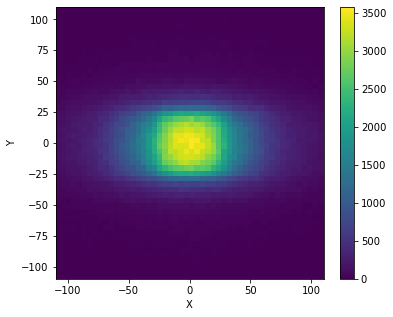

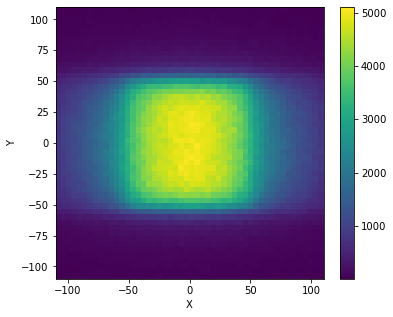

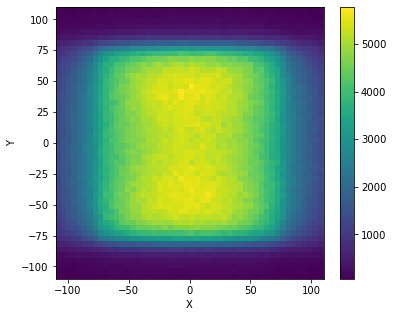

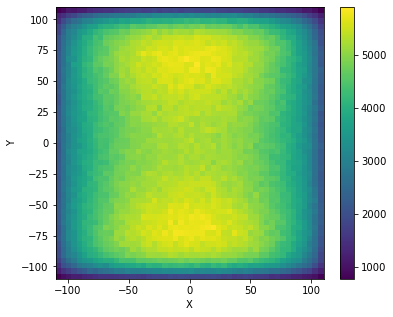

In [8]:
for files_g in filenames_g:
    plt.subplots(1,1,figsize=(6,5))
    # creating a temporary dataframe to hold the one we're currently interating over
    df=data_frame_dict[files_g]
    _=plt.hist2d(df['X'],df['Y'],bins=(50,50))
#     plt.xlim(-100,100)
#     plt.ylim(-100,100)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.colorbar()
    plt.show()


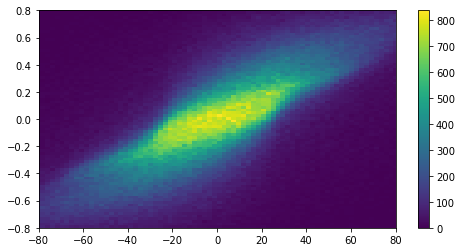

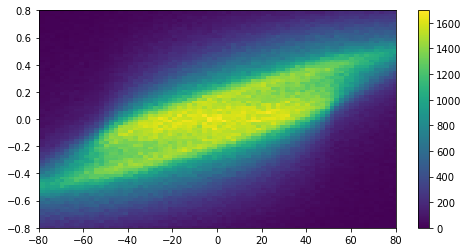

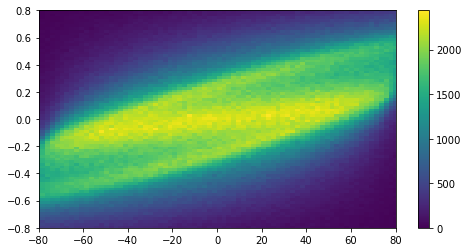

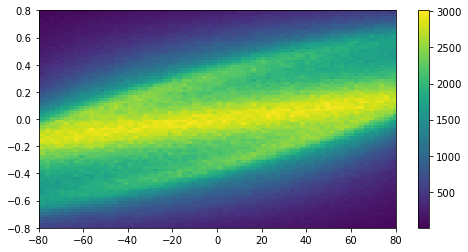

In [9]:
for files_g in filenames_g:
    plt.subplots(1,1,figsize=(8,4))
    df=data_frame_dict[files_g]
    
    _=plt.hist2d(df['X'],df['dX'],bins=(100,100))
    #using _ just suppresses the output if plt.hist2d
    plt.xlim(-80,80)
    plt.ylim(-0.8,0.8)
    plt.colorbar()
    plt.show()


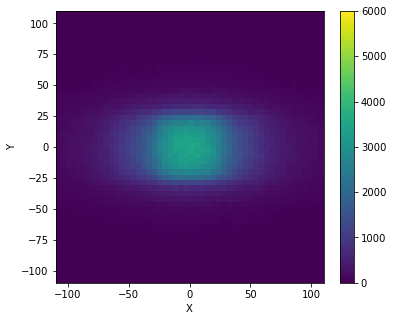

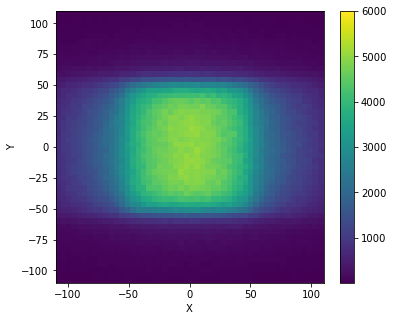

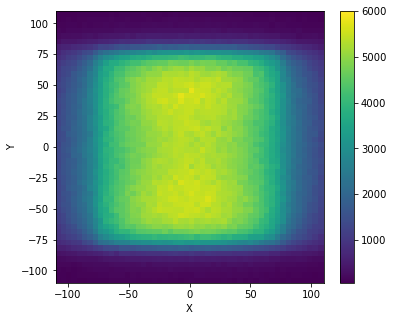

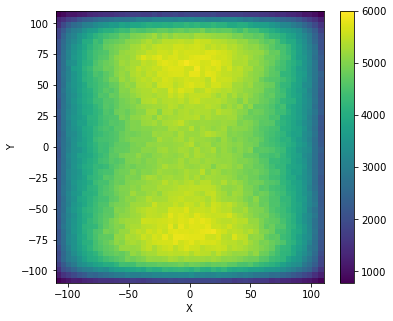

In [27]:
for files_g in filenames_g:
    plt.subplots(1,1,figsize=(6,5))
    # creating a temporary dataframe to hold the one we're currently interating over
    df=data_frame_dict[files_g]
    _=plt.hist2d(df['X'],df['Y'],bins=(50,50),weights=df['Weight'],vmax=6000)
#     plt.xlim(-100,100)
#     plt.ylim(-100,100)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.colorbar()
    plt.show()


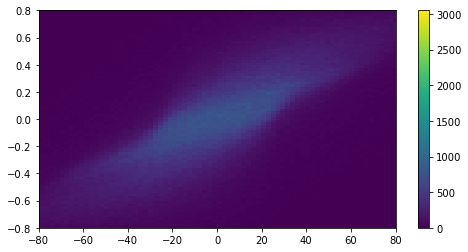

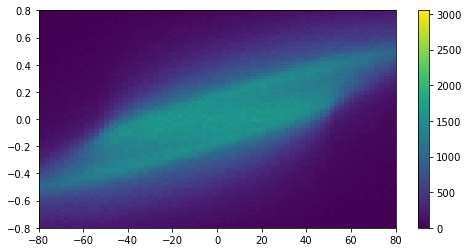

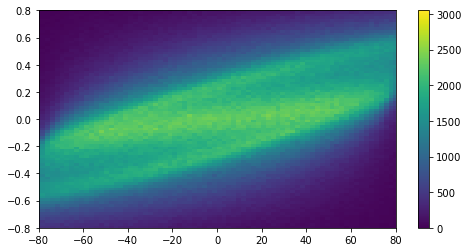

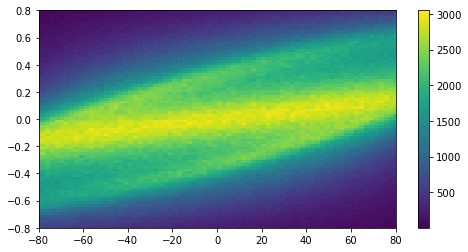

In [26]:
for files_g in filenames_g:
    plt.subplots(1,1,figsize=(8,4))
    df=data_frame_dict[files_g]
    
    _=plt.hist2d(df['X'],df['dX'],weights=df['Weight'],bins=(100,100),vmax=3050)
    #using _ just suppresses the output if plt.hist2d
    plt.xlim(-80,80)
    plt.ylim(-0.8,0.8)
    plt.colorbar()
    plt.show()


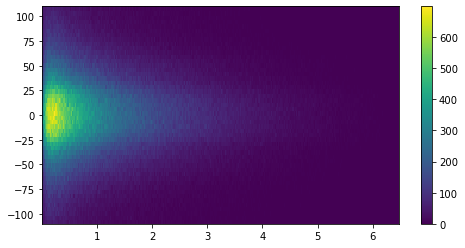

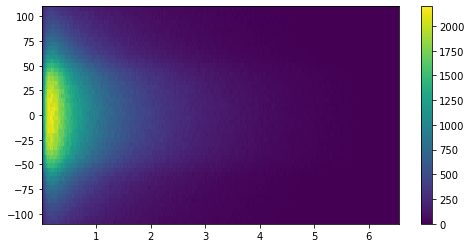

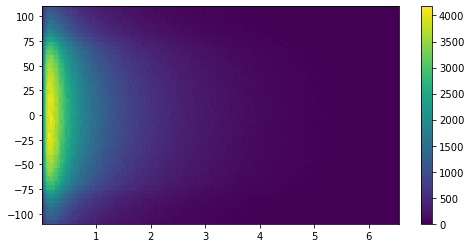

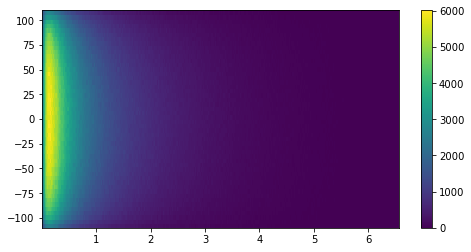

In [32]:
for files_g in filenames_g:
    plt.subplots(1,1,figsize=(8,4))
    df=data_frame_dict[files_g]
    _=plt.hist2d(df['Ekine'],df['X'],weights=df['Weight'],bins=(300,50))
#     plt.xlim(-80,80)
#     plt.ylim(-0.7,0.7)
    plt.colorbar()
    plt.show()


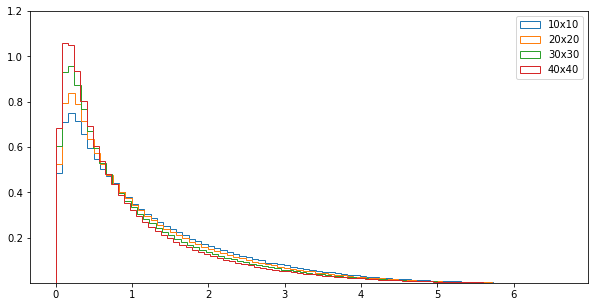

/gate/source/mybeam/gps/hist/point 0.0001 685.83
/gate/source/mybeam/gps/hist/point 0.0812 1057.33
/gate/source/mybeam/gps/hist/point 0.1623 1048.04
/gate/source/mybeam/gps/hist/point 0.2435 935.06
/gate/source/mybeam/gps/hist/point 0.3246 801.91
/gate/source/mybeam/gps/hist/point 0.4057 693.00
/gate/source/mybeam/gps/hist/point 0.4868 606.45
/gate/source/mybeam/gps/hist/point 0.5680 537.96
/gate/source/mybeam/gps/hist/point 0.6491 482.27
/gate/source/mybeam/gps/hist/point 0.7302 434.94
/gate/source/mybeam/gps/hist/point 0.8113 390.44
/gate/source/mybeam/gps/hist/point 0.8924 353.75
/gate/source/mybeam/gps/hist/point 0.9736 322.42
/gate/source/mybeam/gps/hist/point 1.0547 296.98
/gate/source/mybeam/gps/hist/point 1.1358 271.32
/gate/source/mybeam/gps/hist/point 1.2169 249.27
/gate/source/mybeam/gps/hist/point 1.2981 228.74
/gate/source/mybeam/gps/hist/point 1.3792 212.89
/gate/source/mybeam/gps/hist/point 1.4603 198.16
/gate/source/mybeam/gps/hist/point 1.5414 182.20
/gate/source/mybea

In [16]:
plt.subplots(1,1,figsize=(10,5))

for files_g in filenames_g:
        df=data_frame_dict[files_g]
        y,x,_=plt.hist(df['Ekine'],density=True,histtype='step',bins=(80),label=files_g[30:-33])
#         print(f"{midpoints(y)} and x {x}")

# plt.yscale('log')
plt.legend()
# plt.xlim(0,5.8)
plt.ylim(0.001,1.2)
plt.show()

for j,yi in enumerate(y):
    print(f"/gate/source/mybeam/gps/hist/point {x[j]:.4f} {y[j]*1000:.2f}")
    
    
    


KeyboardInterrupt



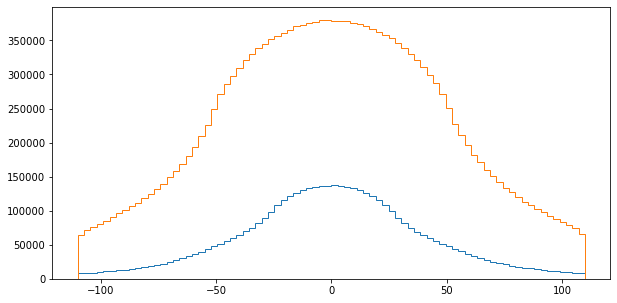

In [4]:
plt.subplots(1,1,figsize=(10,5))

for files_g in filenames_g:

        _=plt.hist(data_frame_dict[files_g]['X'],weights=data_frame_dict[files_g]['Weight'],histtype='step',bins=(80),label=files_g[30:-13])

plt.yscale('log')
plt.legend()
# plt.xlim(0,5.8)
# plt.ylim(0.001,1)
plt.show()


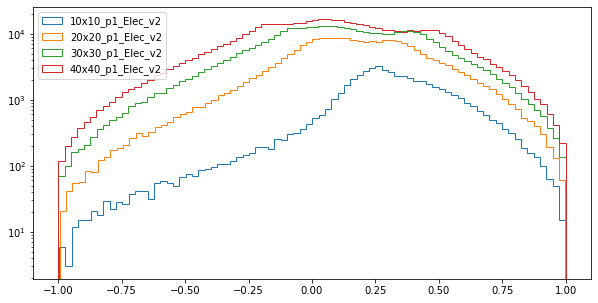

In [22]:
plt.subplots(1,1,figsize=(10,5))

for files_g in filenames_g:

    _=plt.hist(data_frame_dict[files_g]['dX'][data_frame_dict[files_g]['X']<40][data_frame_dict[files_g]['X']>30],histtype='step',bins=(80),label=files_g[30:-13])

plt.yscale('log')
plt.legend(loc="upper left")
# plt.xlim(0,5.8)
# plt.ylim(0.001,1)
plt.show()


In [10]:
filenames_g=[
            "/work/lb8075/PhaseSpaces/PhS1AB_Gamma_Params/output-PhS_bias100_3.root",\
            "/work/lb8075/PhaseSpaces/PhS1AB_Gamma_Params/output-PhS_bias1_3.root"
]


In [11]:

data_frame_dict={}

for files_g in filenames_g:
    print(f"{files_g}   \n")
    ur=uproot.pandas.iterate(files_g, "PhaseSpace", ['X','Y','dX','dY','Weight','Ekine','ProductionVolume','CreatorProcess'])
    #This creates a set of dataframes for each files as it iterates through the * wildcards
    mylist=list(ur)        
    data_frame_dict[files_g]=pd.concat(mylist, ignore_index=True, sort=False  ,copy = False)
    #The concat method then stitches all the pandas data frames for each file together into one data frame
    #which is then stored in a dictionary, accessed by the the key files_g, whatever the filename is



/work/lb8075/PhaseSpaces/PhS1AB_Gamma_Params/output-PhS_bias100_3.root   

/work/lb8075/PhaseSpaces/PhS1AB_Gamma_Params/output-PhS_bias1_3.root   



In [46]:
for files_g in filenames_g:
#     print(data_frame_dict[files_g]['ProductionVolume'].value_counts())
    print(data_frame_dict[files_g].groupby('ProductionVolume')['Weight'].sum())


ProductionVolume
b'back_scatter_plate_log'                  26.109999
b'flattening_filter_cone1_log'              0.360000
b'flattening_filter_cone2_log'              2.610000
b'flattening_filter_cone3_log'              7.550000
b'flattening_filter_cone4_log'             26.980000
b'flattening_filter_cone5_log'             60.689999
b'flattening_filter_cone6_log'             45.029999
b'flattening_filter_log'                    0.050000
b'ionizing_chamber_log'                     0.030000
b'ionizing_chamber_mylar_1ayer1_log'        0.030000
b'ionizing_chamber_mylar_1ayer2_log'        0.020000
b'ionizing_chamber_mylar_1ayer3_log'        0.040000
b'ionizing_chamber_mylar_1ayer4_log'        0.040000
b'ionizing_chamber_mylar_1ayer5_log'        0.020000
b'ionizing_chamber_mylar_1ayer6_log'        0.020000
b'linac_log'                                1.090000
b'mirror_aluminium_log'                     0.010000
b'mirror_mylar_log'                         0.010000
b'primary_collimator_log'    

<U10
float16


TypeError: cannot perform reduce with flexible type

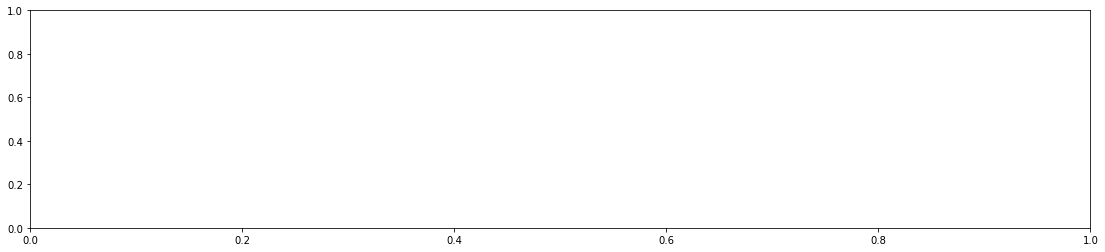

In [43]:
for files_g in filenames_g:
    plt.subplots(1,1,figsize=(19,4))
# creating a temporary dataframe to hold the one we're currently interating over
    df=data_frame_dict[files_g]
    np2=df['CreatorProcess'].to_numpy(dtype="str")
    np3=df['Weight'].to_numpy(dtype="float16")
    np2=np2.astype('str')
    print(np2.dtype)
    print(np3.dtype)

# plt.hist(df['ProductionVolume'])
# print(df.dtypes)
# df['ProductionVolume']=df['ProductionVolume'].astype('str')
# print(df.dtypes)

#     df['Weight'].astype('float16')
# print(df.dtypes)

# print(df2)
# _=plt.hist(df3)
#     plt.xlim(-100,100)
#     plt.ylim(-100,100)
#     plt.xlabel('X')
#     plt.ylabel('Y')
#     plt.colorbar()
# plt.show()
# df2=df['ProductionVolume']
# print(df['ProductionVolume'].dtypes)
# df['ProductionVolume']=df['ProductionVolume'].astype('str')
# print(df['ProductionVolume'].dtypes)

#     df['CreatorProcess'].value_counts().plot(kind='bar',logy=True, ylim=(1,5500000))
    plt.hist2d(np2,np3)

## Inspecting phase 1A

In [38]:
filenames_g=[
            "/work/lb8075/PhaseSpaces/PhS1A_Gamma/output-1A_bias100_3.root",\
            "/work/lb8075/PhaseSpaces/PhS1A_Gamma/output-1A_bias1_3.root"
]

#ran 10x more bias 1 than bias 100

In [133]:
data_frame_dict={}

for files_g in filenames_g:
    print(f"{files_g}   \n")
    ur=uproot.pandas.iterate(files_g, "PhaseSpace", ['X','Y','dX','dY','Weight','Ekine','ParticleName','ProductionVolume','CreatorProcess'])
    #This creates a set of dataframes for each files as it iterates through the * wildcards
    mylist=list(ur)        
    data_frame_dict[files_g]=pd.concat(mylist, ignore_index=True, sort=False  ,copy = False)
    #The concat method then stitches all the pandas data frames for each file together into one data frame
    #which is then stored in a dictionary, accessed by the the key files_g, whatever the filename is



/work/lb8075/PhaseSpaces/PhS1A_Gamma/output-1A_bias100_3.root   

/work/lb8075/PhaseSpaces/PhS1A_Gamma/output-1A_bias1_3.root   



In [40]:
for files_g in filenames_g:
#     print(data_frame_dict[files_g]['ProductionVolume'].value_counts())
    print(data_frame_dict[files_g].groupby('ProductionVolume')['Weight'].sum())


ProductionVolume
b'linac_log'                       45.899998
b'primary_collimator_log'         913.559998
b'target_log'                   62531.429688
b'target_support_bottom_log'     3568.510010
b'target_support_top_log'        4949.299805
Name: Weight, dtype: float32
ProductionVolume
b'linac_log'                       477.0
b'primary_collimator_log'         8964.0
b'target_log'                   627050.0
b'target_support_bottom_log'     34722.0
b'target_support_top_log'        49416.0
Name: Weight, dtype: float32


/work/lb8075/PhaseSpaces/PhS1A_Gamma/output-1A_bias100_3.root
/work/lb8075/PhaseSpaces/PhS1A_Gamma/output-1A_bias1_3.root


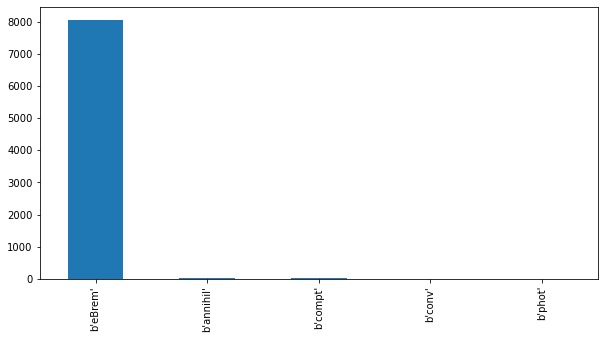

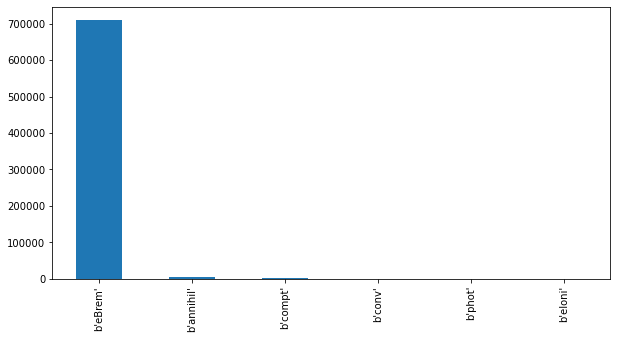

In [41]:
for files_g in filenames_g:
    plt.subplots(1,1,figsize=(10,5))
    print(files_g)
#     print(data_frame_dict[files_g]['ProductionVolume'].value_counts())
    df=data_frame_dict[files_g]
    df['CreatorProcess']=df['CreatorProcess'].astype("str")

#     df['Weight'][df['Weight']<0.5].plot(kind='bar')
#     (df['ProductionVolume'][df['Weight']>0.5]).value_counts().plot(kind='bar')
    (df['CreatorProcess'][df['Weight']>0.5]).value_counts().plot(kind='bar')
    

/work/lb8075/PhaseSpaces/PhS1A_Gamma/output-1A_bias1_3.root
/work/lb8075/PhaseSpaces/PhS1A_Gamma/output-1A_bias100_3.root
/work/lb8075/PhaseSpaces/PhS1A_Gamma/output-1A_bias1_3.root


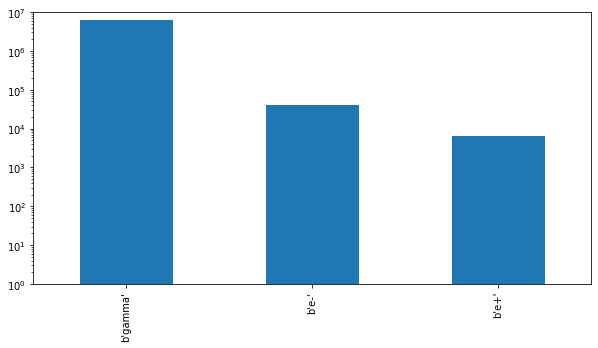

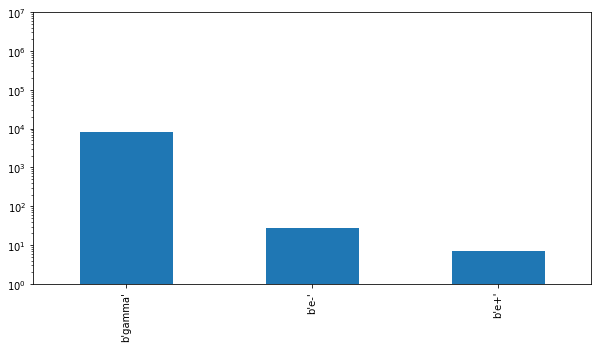

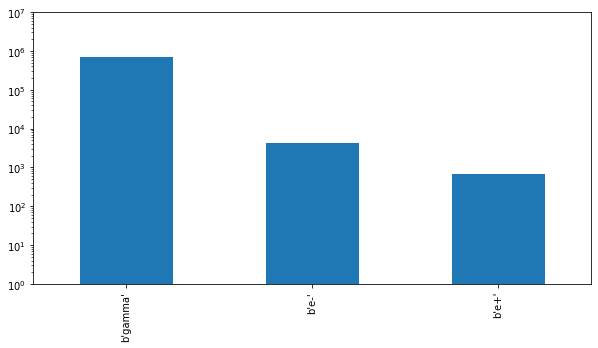

In [42]:
plt.subplots(1,1,figsize=(10,5))
print(files_g)
#     print(data_frame_dict[files_g]['ProductionVolume'].value_counts())
df=data_frame_dict["/work/lb8075/PhaseSpaces/PhS1A_Gamma/output-1A_bias100_3.root"]
df['ProductionVolume']=df['ProductionVolume'].astype("str")

#     df['Weight'][df['Weight']<0.5].plot(kind='bar')
#     (df['ProductionVolume'][df['Weight']>0.5]).value_counts().plot(kind='bar')
(df['ParticleName'][df['Weight']<0.5]).value_counts().plot(kind='bar',logy=True,ylim=(1,10000000))
                   
for files_g in filenames_g:
    plt.subplots(1,1,figsize=(10,5))
    print(files_g)
#     print(data_frame_dict[files_g]['ProductionVolume'].value_counts())
    df=data_frame_dict[files_g]
    df['ProductionVolume']=df['ProductionVolume'].astype("str")

#     df['Weight'][df['Weight']<0.5].plot(kind='bar')
#     (df['ProductionVolume'][df['Weight']>0.5]).value_counts().plot(kind='bar')
    (df['ParticleName'][df['Weight']>0.5]).value_counts().plot(kind='bar',logy=True,ylim=(1,10000000))
    

/work/lb8075/PhaseSpaces/PhS1A_Gamma/output-1A_bias1_3.root
/work/lb8075/PhaseSpaces/PhS1A_Gamma/output-1A_bias100_3.root
/work/lb8075/PhaseSpaces/PhS1A_Gamma/output-1A_bias1_3.root


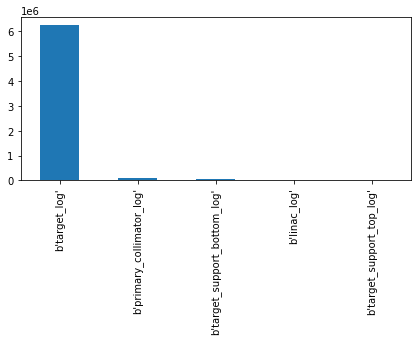

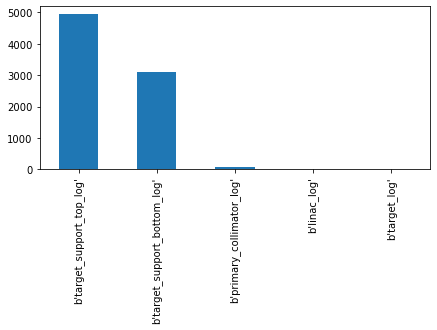

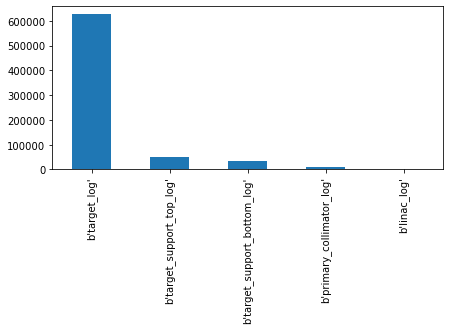

In [49]:
plt.subplots(1,1,figsize=(7,3))
print(files_g)
#     print(data_frame_dict[files_g]['ProductionVolume'].value_counts())
df=data_frame_dict["/work/lb8075/PhaseSpaces/PhS1A_Gamma/output-1A_bias100_3.root"]
df['ProductionVolume']=df['ProductionVolume'].astype("str")

#     df['Weight'][df['Weight']<0.5].plot(kind='bar')
#     (df['ProductionVolume'][df['Weight']>0.5]).value_counts().plot(kind='bar')
(df['ProductionVolume'][df['Weight']<0.5]).value_counts().plot(kind='bar',sort_columns=True)
    
for files_g in filenames_g:
    plt.subplots(1,1,figsize=(7,3))
    print(files_g)
#     print(data_frame_dict[files_g]['ProductionVolume'].value_counts())
    df=data_frame_dict[files_g]
    df['ProductionVolume']=df['ProductionVolume'].astype("str")

#     df['Weight'][df['Weight']<0.5].plot(kind='bar')
#     (df['ProductionVolume'][df['Weight']>0.5]).value_counts().plot(kind='bar')
    (df['ProductionVolume'][df['Weight']>0.5]).value_counts().plot(kind='bar',sort_columns=True)
    

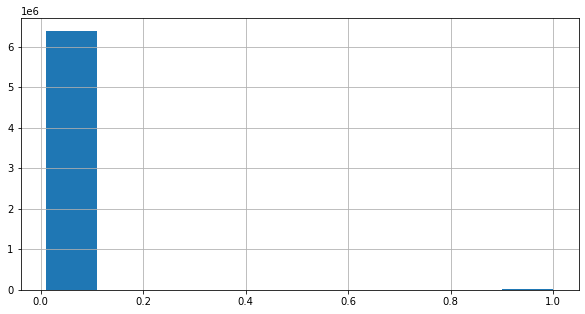

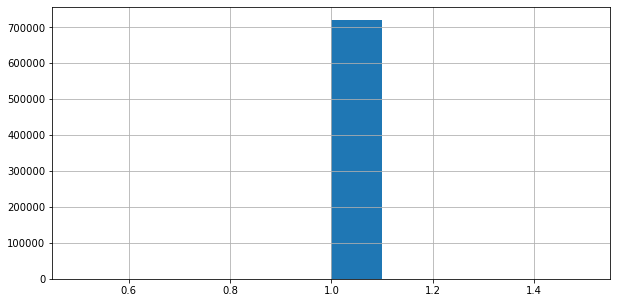

In [81]:
for files_g in filenames_g:
    plt.subplots(1,1,figsize=(10,5))

#     print(data_frame_dict[files_g]['ProductionVolume'].value_counts())
    df=data_frame_dict[files_g]
#     df['ProductionVolume']=df['ProductionVolume'].astype("str")

    df['Weight'].hist()

In [82]:
for files_g in filenames_g:
    print(data_frame_dict[files_g]['X'].count())

6397287
720629


In [83]:
for files_g in filenames_g:
    print(data_frame_dict[files_g]['Weight'].value_counts())

0.01    6389170
1.00       8117
Name: Weight, dtype: int64
1.0    720629
Name: Weight, dtype: int64


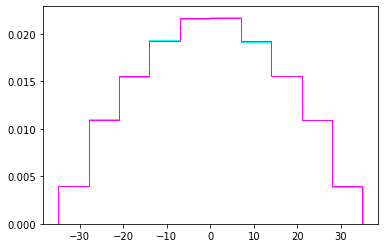

In [54]:
for j,files_g in enumerate(filenames_g):
    df=data_frame_dict[files_g]
    if j==0:
        col="cyan"
    else:
        col="magenta"
    plt.hist(df['X'],density=True,weights=df['Weight'],histtype='step',color=col)

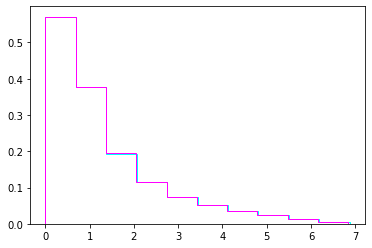

In [55]:
for j,files_g in enumerate(filenames_g):
    df=data_frame_dict[files_g]
    if j==0:
        col="cyan"
    else:
        col="magenta"
    plt.hist(df['Ekine'],density=True,weights=df['Weight'],histtype='step',color=col)

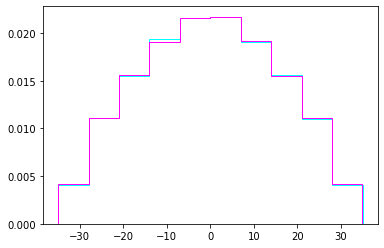

In [57]:
for j,files_g in enumerate(filenames_g):
    df=data_frame_dict[files_g]
    if j==0:
        col="cyan"
    else:
        col="magenta"
    plt.hist(df['X'][df['Y']<1],density=True,weights=df['Weight'][df['Y']<1],histtype='step',color=col)

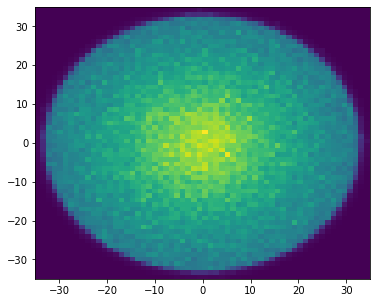

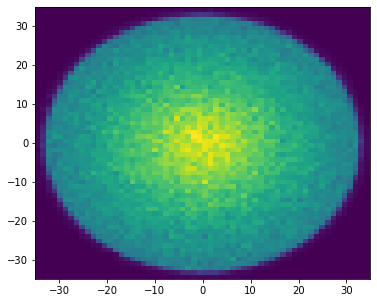

In [105]:
for j,files_g in enumerate(filenames_g):
    plt.subplots(1,1,figsize=(6,5))

    df=data_frame_dict[files_g]

    plt.hist2d(df['X'][df['ParticleName']==b'gamma'],df['Y'][df['ParticleName']==b'gamma'],weights=df['Weight'][df['ParticleName']==b'gamma'],bins=(60,60))

<ipython-input-119-3147e63f62f1>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  dfsubgamma=df[["ProductionVolume","CreatorProcess","ParticleName","Weight"]][df['Weight']>0.5][df['ParticleName']==b"gamma"]


<AxesSubplot:>

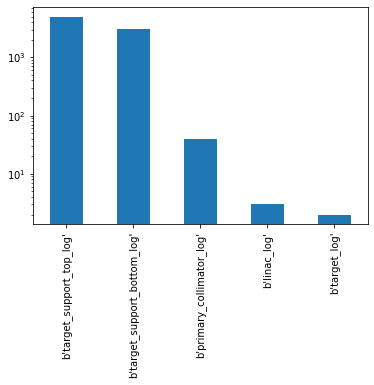

In [119]:
df=data_frame_dict["/work/lb8075/PhaseSpaces/PhS1A_Gamma/output-1A_bias100_3.root"]
dfsubgamma=df[["ProductionVolume","CreatorProcess","ParticleName","Weight"]][df['Weight']>0.5][df['ParticleName']==b"gamma"]
dfsubgamma["ProductionVolume"].value_counts().plot(kind='bar',logy=True)

In [135]:
df=data_frame_dict["/work/lb8075/PhaseSpaces/PhS1A_Gamma/output-1A_bias100_3.root"]
df
# dfsubgamma=df[df['CreatorProcess']==b'eBrem']
# dfsubgamma

,X,Y,dX,dY,Weight,Ekine,ParticleName,ProductionVolume,CreatorProcess
0,-17.864958,14.914584,-0.148810,0.115734,0.01,1.921239,b'gamma',b'target_log',b'eBrem'
1,-16.721224,9.108189,-0.140502,0.068597,0.01,1.141391,b'gamma',b'target_log',b'eBrem'
2,-19.615055,26.802326,-0.150616,0.224681,0.01,0.652369,b'gamma',b'target_log',b'eBrem'
3,-1.926445,-18.622019,-0.010104,-0.140561,0.01,0.258096,b'gamma',b'target_log',b'eBrem'
4,8.471407,13.752536,0.074765,0.123962,0.01,0.400802,b'gamma',b'target_log',b'eBrem'
...,...,...,...,...,...,...,...,...,...
6397282,13.264800,-12.153621,0.106419,-0.119733,0.01,0.510999,b'gamma',b'target_log',b'annihil'
6397283,0.952155,-30.340633,0.002108,-0.261523,0.01,1.279553,b'gamma',b'target_log',b'eBrem'
6397284,24.300293,-23.104897,0.187046,-0.203105,0.01,0.959160,b'gamma',b'target_log',b'eBrem'
6397285,24.425055,-21.418388,0.188494,-0.190210,0.01,0.771434,b'gamma',b'target_log',b'eBrem'


In [140]:
dfsubgamma=df[df['ProductionVolume']==b'target_log'][df['Weight']>0.5][df['ParticleName']==b'gamma']
dfsubgamma

<ipython-input-140-7325a00515fd>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  dfsubgamma=df[df['ProductionVolume']==b'target_log'][df['Weight']>0.5][df['ParticleName']==b'gamma']


,X,Y,dX,dY,Weight,Ekine,ParticleName,ProductionVolume,CreatorProcess
5327858,5.762462,17.360178,0.062030,0.126763,1.0,0.510999,b'gamma',b'target_log',b'annihil'
6195841,-3.320410,-22.802122,-0.044567,-0.193587,1.0,0.251183,b'gamma',b'target_log',b'annihil'


<ipython-input-107-368357d70ca4>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  dfsubelec=df[["ProductionVolume","CreatorProcess","ParticleName","Weight"]][df['Weight']>0.5][df['ParticleName']==b"e-"].head(1000)


<AxesSubplot:>

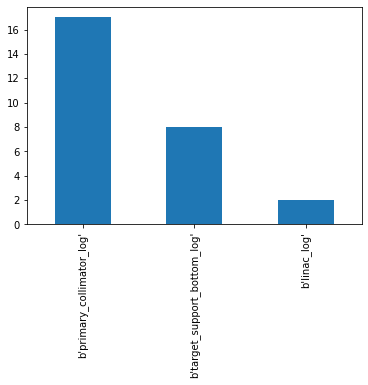

In [107]:
df=data_frame_dict["/work/lb8075/PhaseSpaces/PhS1A_Gamma/output-1A_bias100_3.root"]
dfsubelec=df[["ProductionVolume","CreatorProcess","ParticleName","Weight"]][df['Weight']>0.5][df['ParticleName']==b"e-"]
dfsubelec["ProductionVolume"].value_counts().plot(kind='bar')

In [99]:
pd.set_option('display.max_rows',1000)


<AxesSubplot:>

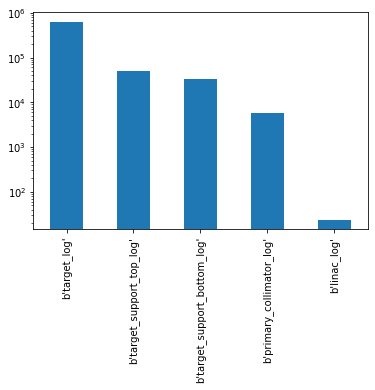

In [145]:
df1=data_frame_dict["/work/lb8075/PhaseSpaces/PhS1A_Gamma/output-1A_bias1_3.root"]
dfsubgamma=df1[["ProductionVolume","CreatorProcess","ParticleName","Weight"]][df1['ParticleName']==b"gamma"]
dfsubgamma["ProductionVolume"].value_counts().plot(kind='bar',logy=True)


In [ ]:
# plt.subplots(1,1,figsize=(15,10))

for j,files_g in enumerate(filenames_g):
    df=data_frame_dict[files_g]
    dfsubgamma=df[["ProductionVolume","CreatorProcess","ParticleName","Weight"]][df['ParticleName']==b"gamma"]
    # dfsubgamma["ProductionVolume"].value_counts().plot(kind='bar',logy=True)
    print(dfsubgamma.groupby('ProductionVolume')['Weight'].value_counts())
    print("")

<AxesSubplot:>

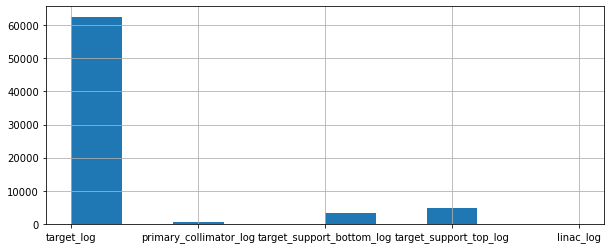

In [160]:
plt.subplots(1,1,figsize=(10,4))
df["ProductionVolume"][df['ParticleName']==b"gamma"].hist(histtype='bar', weights=df['Weight'][df['ParticleName']==b"gamma"])

TypeError: 'AxesSubplot' object is not subscriptable

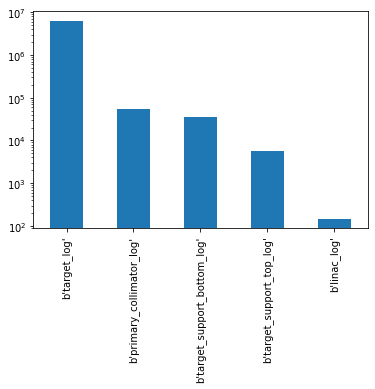

In [161]:
df=data_frame_dict["/work/lb8075/PhaseSpaces/PhS1A_Gamma/output-1A_bias100_3.root"]
dfsubgamma=df[["ProductionVolume","CreatorProcess","ParticleName","Weight"]][df['ParticleName']==b"gamma"]
# dfsubgamma["ProductionVolume"].value_counts().plot(kind='bar',logy=True)[df['ParticleName']==b"gamma"]
df["ProductionVolume"][df['ParticleName']==b"gamma"].hist(histtype='bar', weights=df['Weight'][df['ParticleName']==b"gamma"])

/work/lb8075/PhaseSpaces/PhS1A_Gamma/output-1A_bias100_3.root
/work/lb8075/PhaseSpaces/PhS1A_Gamma/output-1A_bias1_3.root


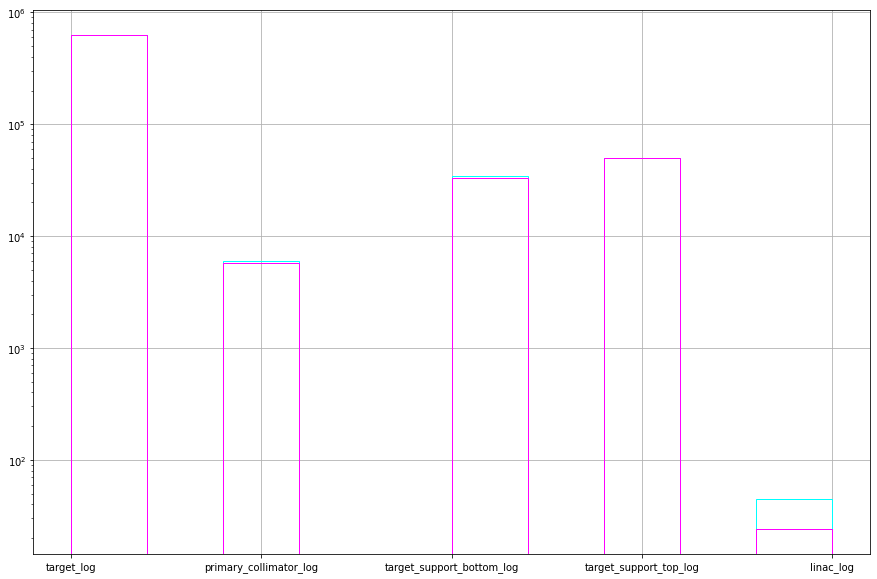

In [168]:
plt.subplots(1,1,figsize=(15,10))

for j,files_g in enumerate(filenames_g):
    df=data_frame_dict[files_g]
    print(files_g)
    if j==0:
        col="cyan"
        factor=10
    else:
        col="magenta"
        factor=1
    df["ProductionVolume"][df['ParticleName']==b"gamma"].hist(histtype='step',log=True, weights=factor*df['Weight'][df['ParticleName']==b"gamma"],color=col)

In [7]:
filenames_g=[
            "/work/lb8075/PhaseSpaces/PhS1AB_Gamma_ZeroBias/output-PhS_bias1_76.root"
]

In [20]:
data_frame_dict={}

for files_g in filenames_g:
    print(f"{files_g}   \n")
    ur=uproot.pandas.iterate(files_g, "PhaseSpace", ['X','Y','dX','dY','dZ','Weight','Ekine','ProductionVolume','CreatorProcess'])
    #This creates a set of dataframes for each files as it iterates through the * wildcards
    mylist=list(ur)        
    data_frame_dict[files_g]=pd.concat(mylist, ignore_index=True, sort=False  ,copy = False)
    #The concat method then stitches all the pandas data frames for each file together into one data frame
    #which is then stored in a dictionary, accessed by the the key files_g, whatever the filename is


/work/lb8075/PhaseSpaces/PhS1AB_Gamma_ZeroBias/output-PhS_bias1_76.root   



In [32]:
for j,files_g in enumerate(filenames_g):

    df=data_frame_dict[files_g]
    data_frame_dict[files_g]['dXdY']=(data_frame_dict[files_g].dX**2+data_frame_dict[files_g].dY**2)**0.5
    ratioThetaXY=data_frame_dict[files_g].dXdY/data_frame_dict[files_g].dZ
    ratioThetaX=data_frame_dict[files_g].dX/data_frame_dict[files_g].dZ
    ratioThetaY=data_frame_dict[files_g].dX/data_frame_dict[files_g].dZ
    data_frame_dict[files_g]['thetaXY']=ratioThetaXY.apply(math.atan)*180/3.14
    data_frame_dict[files_g]['thetaX']=ratioThetaX.apply(math.atan)*180/3.14
    data_frame_dict[files_g]['thetaY']=ratioThetaY.apply(math.atan)*180/3.14
    data_frame_dict[files_g]['XY']=(data_frame_dict[files_g].X**2+data_frame_dict[files_g].Y**2)**0.5


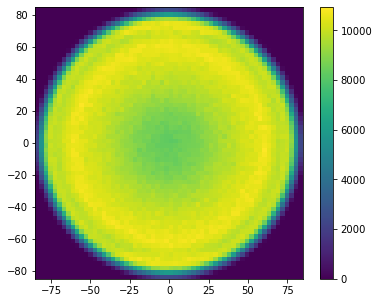

In [12]:
for j,files_g in enumerate(filenames_g):
    plt.subplots(1,1,figsize=(6,5))

    df=data_frame_dict[files_g]

    plt.hist2d(df['X'],df['Y'],weights=df['Weight'],bins=(60,60))
    plt.colorbar()

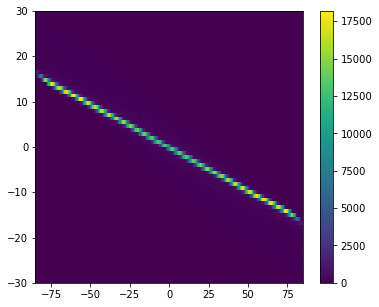

In [31]:
for j,files_g in enumerate(filenames_g):
    plt.subplots(1,1,figsize=(6,5))

    df=data_frame_dict[files_g]

    _=plt.hist2d(df['X'][df['Y']<10][df['Y']>-10],df['thetaX'][df['Y']<10][df['Y']>-10],weights=df['Weight'][df['Y']<10][df['Y']>-10],bins=(200,200))
    plt.ylim(-30,30)
    plt.colorbar()

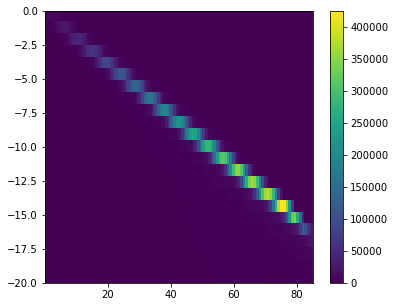

In [40]:
for j,files_g in enumerate(filenames_g):
    plt.subplots(1,1,figsize=(6,5))

    df=data_frame_dict[files_g]

    _=plt.hist2d(df['XY'],df['thetaXY'],weights=df['Weight'],bins=(100,200))
    plt.ylim(-20,0)
    plt.colorbar()